In [1]:
import joblib
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.colors as colors
from matplotlib_venn import venn2
import statistics 
import random
import csv

%matplotlib inline

In [2]:
pd.options.mode.chained_assignment = None 

In [3]:
HERE = os.path.dirname(os.path.abspath('__file__'))
ROOT = os.path.abspath(os.path.join(HERE, os.pardir))
DATA = os.path.join(ROOT, 'data')

SSGSEA_LIHC_KEGG = os.path.join(
    DATA,
    "kegg_lihc.tsv"
)

TRAINED_MODEL = os.path.join(
    DATA,
    'trained_models',
    "lihc_trained_model.joblib"
)

LIHC_LABELS = os.path.join(
    DATA,
    "phenoty
    pe_classes_lihc.cls"
)
DRUGCENTRAL_TO_GENES_ID = os.path.join(
    DATA,
    "drugcentral_mapped_to_drugbank.tsv"
)
DRUGBANK_TO_GENES_ID = os.path.join(
    DATA,
    "drugbank_to_genes_ID.csv"
)

ALL_HGNC_GENES = os.path.join(
    DATA,
    "hgnc_symbols.csv"
)

GENE_SETS_KEGG = os.path.join(
    DATA,
    "kegg_geneset_final.gmt"
)

In [4]:
## Lable preparation

lihc_labels = pd.read_csv(LIHC_LABELS, sep = "\t")
lihc_labels.drop(lihc_labels.index[0], inplace=True)
lihc_labels = lihc_labels.rename(index={1:'label'})
lihc_labels = lihc_labels.transpose()

temp_lable = []

for lable in lihc_labels.label:
    temp_lable = lable.split(' ')

In [5]:
## Patient_Pathway dataframe preparation

#lable_list = []

# Transpose the dataframe's columns and rows
raw_data = pd.read_csv(SSGSEA_LIHC_KEGG, sep = "\t", index_col=0).transpose()

# Append the data lable as a column to main dataframe
raw_data.insert(311, "label", temp_lable, True)

# Convert the data lable into numerical value
num_labels = {"Normal": 0, "Tumor": 1} 
raw_data.label = [num_labels[item] for item in raw_data.label]

lable_list = list(raw_data.label.values)

# Removing the index column 
raw_data.reset_index(drop=True, inplace=True)

In [6]:
def parse_gmt_file(gmt_path: str, min_size=3, max_size=3000):
    """Parse gmt file of pathways and their corresponding genes."""
    with open(gmt_path) as f:
        genesets_dict = {
            line.strip().split("\t")[0]: line.strip().split("\t")[2:]
            for line in f
        }
    return genesets_dict

In [7]:
pathway_genes_dict = parse_gmt_file(GENE_SETS_KEGG)

In [8]:
#HGNC_ID_map_to_gene_name = pd.read_csv(HGNC_ID_MAP_TO_GENE_NAME, sep = "\t")
all_hgnc_genes = pd.read_csv(ALL_HGNC_GENES, sep = "\t")

In [9]:
## Read the drugbank_to_genes file and filter all source_databases but drugbank

drugbank_to_genes_ID = pd.read_csv(DRUGBANK_TO_GENES_ID,sep = "\t")

In [10]:
## Filter all source_databases but drugbank
drugbank_to_genes_ID_keep_drugbank = drugbank_to_genes_ID.loc[drugbank_to_genes_ID['source_database'] == "drugbank"]

for i in range(len(drugbank_to_genes_ID_keep_drugbank["source"])):
    temp_drug = drugbank_to_genes_ID_keep_drugbank["source"].iloc[i]
    temp_drug = temp_drug.split(':')[1]
    drugbank_to_genes_ID_keep_drugbank["source"].iloc[i] = temp_drug

In [11]:
drugcentral = pd.read_csv(DRUGCENTRAL_TO_GENES_ID,sep = "\t")

columnsTitles = ['drugbank_id', 'hgnc_symbol', 'relation']

drugcentral = drugcentral.reindex(columns=columnsTitles)
drugcentral.rename(columns={'drugbank_id': 'source', 'hgnc_symbol': 'target', 'relation': 'relation' }, inplace=True)

In [12]:
#drugbank = drugbank_to_genes_ID_keep_drugbank.drop('source_database', 1)
drugbank = drugbank_to_genes_ID_keep_drugbank['source']
#drugcentral = drugcentral['source']

#mixed_df = drugbank.append(drugcentral)

In [13]:
mixed_df = pd.DataFrame(drugbank)

In [14]:
## Drug dataframe prepration for calculating score of a pathway including all of its involving genes 

# Group the targeting genes based on the drugs
mixed_df_groupby_drug = mixed_df.groupby('source')

# Forming a list of unique drugs used further for preparation of dataframe containing drugs and its targeted pathway 
## and all targeted genes involved in that pathway
unique_drug = mixed_df["source"].unique()

In [15]:
## Load the trained classifier

trained_model = joblib.load(open(TRAINED_MODEL, "rb"))

/home/skhatami/miniconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/skhatami/miniconda3/lib/python3.7/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator GridSearchCV from version 0.23.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [16]:
score_list = [-1,1]

synthetic_data_frame = {}


for i in tqdm(range(100)):
    synthetic_drug_gene_score = pd.DataFrame(columns = ["drug",'Gene','relation'])
    num_data_frame = str(i)
    random_selected_drug = random.sample(list(unique_drug), len(unique_drug))
    for drug in random_selected_drug:
        #num_gene_select = gene_per_drug[drug]
        random_selected_gene = random.sample(list(all_hgnc_genes["hgnc_symbol"]), 1)
        #for gene in random_selected_gene:
        random_selected_relation = random.sample(score_list, 1)
        synthetic_drug_gene_score = synthetic_drug_gene_score.append({'drug': drug, 'Gene':random_selected_gene[0], 'relation':random_selected_relation[0]},ignore_index=True)
    synthetic_data_frame[num_data_frame] = synthetic_drug_gene_score
    del synthetic_drug_gene_score

100%|██████████| 100/100 [09:27<00:00,  5.55s/it]


In [17]:
synthetic_pathway_to_score_data_frame = {}

for df_num, df in tqdm(synthetic_data_frame.items()):
    
    pathway_to_score = pd.DataFrame(columns=['drug_ID','pathway','affection_rate','gene_name'])
    
    temp_df = df.groupby('drug')
    df_drug_unique = df["drug"].unique()
    
    for drug in df_drug_unique:
        
    # get the subset of drugbank dataset with regards to the a data
        temp_drug_gene_relation_df = temp_df.get_group(drug)
    
    # drop the drug column to turn it to dict for efficient looping
        temp_drug_gene_relation_df = temp_drug_gene_relation_df.drop("drug",1)
    
    # convert the subset dataframe to dictionary
        temp_gene_score_dict = dict(temp_drug_gene_relation_df.values.tolist())
    
    # loop over pathway_genes_dict genes and pathways
        for pathways, genes in pathway_genes_dict.items():
            temp_gene= genes
            temp_pathway = pathways
        
        # loop over subset dataframe converted dict genes and scores
            for gene, score in temp_gene_score_dict.items():
                gene_temp = gene
                score_temp = score
            
            # find all genes of a pathway and makeing a dataframe out of that with all details (drug,gene,pathway,affecting score)
                if gene_temp in temp_gene:
                    #pathway_to_score.append([drug,temp_pathway,score_temp,gene_temp])
                    pathway_to_score = pathway_to_score.append({'drug_ID':drug,'pathway': temp_pathway, 'affection_rate': score_temp, 'gene_name': gene_temp},ignore_index=True)
    synthetic_pathway_to_score_data_frame[df_num] = pathway_to_score
    del pathway_to_score

100%|██████████| 100/100 [05:29<00:00,  3.54s/it]


In [18]:
synthetic_pathway_scores_data_frame = {}

for df_num, df in tqdm(synthetic_pathway_to_score_data_frame.items()):
    
    pathway_scores = pd.DataFrame(columns=['drug_ID','Pathway', 'Finall_affected_score'])
    
    pathway_to_score_groupby = df.groupby(['drug_ID','pathway'])
    
    for drug,path,score,gene in df.values:
    
        # get the subset of last step prepared dataframe with regards to the drug and correponding pathway (considering all of its involving genes)
        temp_pathway_to_score_df = pathway_to_score_groupby.get_group((drug,path))
    
        # calculating the sum of the scores for all the genes of a pathway
        temp_affected_score = temp_pathway_to_score_df['affection_rate'].sum()
    
        # calculating the mean 
        finall_affected_score = temp_affected_score / (temp_pathway_to_score_df.shape[0])
    
        # make a dataframe dataframe with a score per drug per pathway
        pathway_scores = pathway_scores.append({'drug_ID':drug,'Pathway': path, 'Finall_affected_score': finall_affected_score},ignore_index=True)
    
    synthetic_pathway_scores_data_frame[df_num] = pathway_scores
    del pathway_scores

100%|██████████| 100/100 [02:17<00:00,  1.42s/it]


In [19]:
## Splite samples based on our desired lables

def splite_samples(raw_data, desired_label):
    
    # Split the subset of pateints having desired lable
    desired_label_sample= raw_data.loc[raw_data['label'] == desired_label]
    
    # Dataframe including the other subset of patients with undisred lable
    undesired_label_sample = pd.concat([raw_data, desired_label_sample]).drop_duplicates(keep=False)
    
    return desired_label_sample, undesired_label_sample

In [20]:
desired_label_sample, undesired_label_sample = splite_samples(raw_data,1)

desired_label_sample.drop('label', axis=1, inplace=True)
undesired_label_sample.drop('label', axis=1, inplace=True)

patients_mean_pathway = {}
healthy_mean_pathway = {}

for pathway in desired_label_sample:
    mean = desired_label_sample[pathway].mean()
    patients_mean_pathway[pathway] = mean

mean = 0
    
for pathway in undesired_label_sample:
    mean = undesired_label_sample[pathway].mean()
    healthy_mean_pathway[pathway] = mean
    
    
patients_mean_pathway_df = pd.DataFrame(patients_mean_pathway.items(), columns=['pathway', 'mean_patient'])
healthy_mean_pathway_df = pd.DataFrame(healthy_mean_pathway.items(), columns=['pathway', 'mean_healthy'])

mean_patient_healthy_pathway = pd.merge(healthy_mean_pathway_df, patients_mean_pathway_df, on=["pathway"])
#mean_patient_healthy_pathway = pd.merge(mean_patient_healthy_pathway, path_coef, on=["pathway"])

In [21]:
mean_patient_healthy_pathway["diff_mean"] = abs(mean_patient_healthy_pathway["mean_healthy"] - mean_patient_healthy_pathway["mean_patient"])
mean_patient_healthy_pathway = mean_patient_healthy_pathway.sort_values(by = 'diff_mean',ascending = False)

In [22]:
## Modify the pathway score of each patient with regards to each drug available in drugbank

def path_score_modification(drug_name, raw_data, desired_label,mean_patient_healthy_pathway):
     
    desired_path_score_changed_sample, undesired_path_score_changed_sample = splite_samples(raw_data, desired_label)
    
    # Get subset of dataframe with a score per drug per pathway with regards to selected drug
    temp_pathway_drug_all_gene_score = df.groupby('drug_ID')
    pathway_drug_including_all_gene_score = temp_pathway_drug_all_gene_score.get_group(drug_name)
    
    # Dictionary of pathways affected by the drug to their respective scores
    affected_pathway_to_score = {
        pathway: score
        for _, pathway, score in pathway_drug_including_all_gene_score.values
    }
                 
    # For each sample id
    for sample in range(len(desired_path_score_changed_sample)):
            
        # For each pathway that we have to modify a score in all patients since it is targetted by the drug
        for pathway in affected_pathway_to_score:
                        
            # Get related affection scored calculated per drug per pathway
            affection_score = affected_pathway_to_score[pathway]
            
            if pathway in desired_path_score_changed_sample.columns:
                
                pathway_column = desired_path_score_changed_sample.columns.get_loc(pathway)
                current_score = desired_path_score_changed_sample.iloc[sample, pathway_column]
                temp_mean_patient_healthy_pathway = mean_patient_healthy_pathway.loc[mean_patient_healthy_pathway['pathway'] == pathway]


                
                if affection_score > 0:
                    
                    if temp_mean_patient_healthy_pathway.iloc[0,3] > np.quantile(mean_patient_healthy_pathway['diff_mean'], 0.75):
                    
                        desired_path_score_changed_sample.iloc[sample, pathway_column] = 20 * abs(current_score)
                        
                    elif np.quantile(mean_patient_healthy_pathway['diff_mean'], 0.75) >= temp_mean_patient_healthy_pathway.iloc[0,3] >= np.quantile(mean_patient_healthy_pathway['diff_mean'], 0.5):
                        
                        desired_path_score_changed_sample.iloc[sample, pathway_column] = 5 * abs(current_score)
                    
                    else:
                        desired_path_score_changed_sample.iloc[sample, pathway_column] = 10 * abs(current_score)
                        
 
                elif affection_score == 0:
                    
                    desired_path_score_changed_sample.iloc[sample, pathway_column] = current_score

                    
                else:
                    
                    if temp_mean_patient_healthy_pathway.iloc[0,3] > np.quantile(mean_patient_healthy_pathway['diff_mean'], 0.75):
                    
                        desired_path_score_changed_sample.iloc[sample, pathway_column] = -20 * abs(current_score)
                        
                    elif np.quantile(mean_patient_healthy_pathway['diff_mean'], 0.75) >= temp_mean_patient_healthy_pathway.iloc[0,3] >= np.quantile(mean_patient_healthy_pathway['diff_mean'], 0.5):
                        
                        desired_path_score_changed_sample.iloc[sample, pathway_column] = -5 * abs(current_score)
                    
                    else:
                        desired_path_score_changed_sample.iloc[sample, pathway_column] = -10 * abs(current_score)
    
    return desired_path_score_changed_sample

In [23]:
def auc_per_drug(drug_data_set,model,data,desired_lable, raw_data_set_lable,mean_patient_healthy_pathway):
    
    pathway_drug_score_lihc = pd.DataFrame(columns=['drug','label_changed_ratio'])

    for drug in df["drug_ID"].unique():
        ratio = 0
        temp_data_set = path_score_modification(drug,raw_data,desired_lable,mean_patient_healthy_pathway)
        prepared_data_set_for_prediction = temp_data_set.iloc[:,:311]
        prediction = trained_model.predict(prepared_data_set_for_prediction)
        for l_o,l_p in zip(raw_data.label,prediction):
            if l_o != l_p and l_o == 1:
                ratio = ratio + 1
        ratio = (ratio/lable_list.count(1))
        pathway_drug_score_lihc = pathway_drug_score_lihc.append({'drug': drug, 'label_changed_ratio': ratio},ignore_index=True)
    return pathway_drug_score_lihc            

In [24]:
permut_dist = pd.DataFrame(columns=['DataFrame_num', 'Prioritized_drugs_num'])


for num_df,df in tqdm(synthetic_pathway_scores_data_frame.items()):
    number_of_prioritized_drugs = 0
        
    pathway_drug_score_lihc_df = auc_per_drug(df,trained_model,raw_data,1,raw_data.label,mean_patient_healthy_pathway)
        
    for drug,label_changed_ratio in pathway_drug_score_lihc_df.values:
        if label_changed_ratio >=0.8:
            number_of_prioritized_drugs = number_of_prioritized_drugs + 1
    print(num_df,number_of_prioritized_drugs)
                
    permut_dist = permut_dist.append({'DataFrame_num': num_df, 'Prioritized_drugs_num': number_of_prioritized_drugs},ignore_index=True)

  1%|          | 1/100 [07:40<12:39:57, 460.58s/it]

0 9


  2%|▏         | 2/100 [13:59<11:52:08, 436.00s/it]

1 7


  3%|▎         | 3/100 [21:00<11:37:50, 431.66s/it]

2 15


  4%|▍         | 4/100 [30:15<12:29:40, 468.55s/it]

3 9


  5%|▌         | 5/100 [40:11<13:22:14, 506.68s/it]

4 14


  6%|▌         | 6/100 [48:42<13:16:08, 508.18s/it]

5 10


  7%|▋         | 7/100 [55:26<12:19:05, 476.83s/it]

6 1


  8%|▊         | 8/100 [1:01:48<11:27:47, 448.56s/it]

7 8


  9%|▉         | 9/100 [1:09:42<11:31:46, 456.12s/it]

8 13


 10%|█         | 10/100 [1:16:05<10:51:01, 434.01s/it]

9 9


 11%|█         | 11/100 [1:25:31<11:42:46, 473.78s/it]

10 8


 12%|█▏        | 12/100 [1:32:43<11:16:33, 461.29s/it]

11 11


 13%|█▎        | 13/100 [1:40:28<11:10:07, 462.15s/it]

12 6


 14%|█▍        | 14/100 [1:48:03<10:59:31, 460.14s/it]

13 8


 15%|█▌        | 15/100 [1:55:29<10:45:56, 455.96s/it]

14 10


 16%|█▌        | 16/100 [2:01:53<10:08:07, 434.37s/it]

15 5


 17%|█▋        | 17/100 [2:08:58<9:56:57, 431.53s/it] 

16 10


 18%|█▊        | 18/100 [2:16:53<10:07:43, 444.68s/it]

17 11


 19%|█▉        | 19/100 [2:26:34<10:55:26, 485.51s/it]

18 10


 20%|██        | 20/100 [2:35:01<10:55:47, 491.84s/it]

19 10


 21%|██        | 21/100 [2:42:18<10:26:09, 475.56s/it]

20 8


 22%|██▏       | 22/100 [2:48:40<9:41:35, 447.38s/it] 

21 9


 23%|██▎       | 23/100 [2:55:27<9:18:25, 435.13s/it]

22 7


 24%|██▍       | 24/100 [3:02:37<9:09:13, 433.60s/it]

23 8


 25%|██▌       | 25/100 [3:09:05<8:44:59, 419.99s/it]

24 9


 26%|██▌       | 26/100 [3:15:52<8:33:20, 416.22s/it]

25 15


 27%|██▋       | 27/100 [3:20:45<7:41:16, 379.13s/it]

26 5


 28%|██▊       | 28/100 [3:29:36<8:29:49, 424.85s/it]

27 13


 29%|██▉       | 29/100 [3:38:50<9:08:35, 463.59s/it]

28 14


 30%|███       | 30/100 [3:46:21<8:56:13, 459.63s/it]

29 7


 31%|███       | 31/100 [3:53:51<8:45:10, 456.68s/it]

30 10


 32%|███▏      | 32/100 [3:59:07<7:50:02, 414.74s/it]

31 9


 33%|███▎      | 33/100 [4:06:24<7:50:26, 421.28s/it]

32 6


 34%|███▍      | 34/100 [4:14:46<8:09:54, 445.37s/it]

33 7


 35%|███▌      | 35/100 [4:22:51<8:15:23, 457.28s/it]

34 14


 36%|███▌      | 36/100 [4:32:31<8:47:00, 494.08s/it]

35 12


 37%|███▋      | 37/100 [4:40:33<8:35:01, 490.50s/it]

36 12


 38%|███▊      | 38/100 [4:48:44<8:26:57, 490.61s/it]

37 12


 39%|███▉      | 39/100 [4:54:59<7:43:44, 456.14s/it]

38 11


 40%|████      | 40/100 [5:03:06<7:45:20, 465.35s/it]

39 7


 41%|████      | 41/100 [5:08:41<6:59:08, 426.24s/it]

40 6


 42%|████▏     | 42/100 [5:17:40<7:24:49, 460.16s/it]

41 7


 43%|████▎     | 43/100 [5:25:31<7:20:00, 463.17s/it]

42 11


 44%|████▍     | 44/100 [5:32:16<6:56:12, 445.94s/it]

43 6


 45%|████▌     | 45/100 [5:38:38<6:31:01, 426.57s/it]

44 8


 46%|████▌     | 46/100 [5:44:51<6:09:33, 410.62s/it]

45 7


 47%|████▋     | 47/100 [5:54:21<6:44:49, 458.29s/it]

46 7


 48%|████▊     | 48/100 [6:00:37<6:15:45, 433.57s/it]

47 6


 49%|████▉     | 49/100 [6:08:28<6:18:08, 444.87s/it]

48 7


 50%|█████     | 50/100 [6:16:34<6:21:03, 457.26s/it]

49 21


 51%|█████     | 51/100 [6:24:03<6:11:30, 454.91s/it]

50 7


 52%|█████▏    | 52/100 [6:32:21<6:14:16, 467.84s/it]

51 8


 53%|█████▎    | 53/100 [6:40:22<6:09:34, 471.80s/it]

52 8


 54%|█████▍    | 54/100 [6:48:11<6:00:55, 470.78s/it]

53 9


 55%|█████▌    | 55/100 [6:56:17<5:56:31, 475.37s/it]

54 9


 56%|█████▌    | 56/100 [7:03:03<5:33:24, 454.65s/it]

55 5


 57%|█████▋    | 57/100 [7:09:51<5:15:40, 440.49s/it]

56 6


 58%|█████▊    | 58/100 [7:16:48<5:03:27, 433.52s/it]

57 7


 59%|█████▉    | 59/100 [7:24:11<4:58:10, 436.36s/it]

58 7


 60%|██████    | 60/100 [7:32:10<4:59:21, 449.04s/it]

59 5


 61%|██████    | 61/100 [7:39:50<4:54:03, 452.40s/it]

60 9


 62%|██████▏   | 62/100 [7:46:33<4:37:10, 437.63s/it]

61 9


 63%|██████▎   | 63/100 [7:52:46<4:17:53, 418.21s/it]

62 5


 64%|██████▍   | 64/100 [7:59:49<4:11:44, 419.56s/it]

63 8


 65%|██████▌   | 65/100 [8:06:09<3:57:51, 407.75s/it]

64 6


 66%|██████▌   | 66/100 [8:16:35<4:28:09, 473.22s/it]

65 12


 67%|██████▋   | 67/100 [8:24:47<4:23:24, 478.92s/it]

66 12


 68%|██████▊   | 68/100 [8:31:16<4:01:03, 451.99s/it]

67 9


 69%|██████▉   | 69/100 [8:37:39<3:42:51, 431.34s/it]

68 3


 70%|███████   | 70/100 [8:44:47<3:35:04, 430.15s/it]

69 7


 71%|███████   | 71/100 [8:51:08<3:20:52, 415.61s/it]

70 8


 72%|███████▏  | 72/100 [8:57:55<3:12:41, 412.90s/it]

71 3


 73%|███████▎  | 73/100 [9:05:38<3:12:34, 427.95s/it]

72 7


 74%|███████▍  | 74/100 [9:13:25<3:10:31, 439.69s/it]

73 9


 75%|███████▌  | 75/100 [9:20:39<3:02:25, 437.81s/it]

74 6


 76%|███████▌  | 76/100 [9:26:43<2:46:17, 415.73s/it]

75 5


 77%|███████▋  | 77/100 [9:33:36<2:39:05, 415.01s/it]

76 6


 78%|███████▊  | 78/100 [9:39:41<2:26:38, 399.95s/it]

77 11


 79%|███████▉  | 79/100 [9:47:49<2:29:13, 426.37s/it]

78 11


 80%|████████  | 80/100 [9:54:30<2:19:33, 418.66s/it]

79 11


 81%|████████  | 81/100 [10:03:07<2:21:59, 448.38s/it]

80 9


 82%|████████▏ | 82/100 [10:11:07<2:17:21, 457.89s/it]

81 8


 83%|████████▎ | 83/100 [10:18:46<2:09:46, 458.01s/it]

82 10


 84%|████████▍ | 84/100 [10:26:34<2:03:00, 461.25s/it]

83 3


 85%|████████▌ | 85/100 [10:33:49<1:53:20, 453.34s/it]

84 9


 86%|████████▌ | 86/100 [10:43:30<1:54:39, 491.40s/it]

85 10


 87%|████████▋ | 87/100 [10:53:43<1:54:25, 528.14s/it]

86 18


 88%|████████▊ | 88/100 [11:00:18<1:37:35, 487.97s/it]

87 9


 89%|████████▉ | 89/100 [11:07:37<1:26:46, 473.33s/it]

88 13


 90%|█████████ | 90/100 [11:14:00<1:14:21, 446.20s/it]

89 6


 91%|█████████ | 91/100 [11:20:40<1:04:51, 432.43s/it]

90 8


 92%|█████████▏| 92/100 [11:29:36<1:01:48, 463.56s/it]

91 9


 93%|█████████▎| 93/100 [11:37:25<54:15, 465.07s/it]  

92 5


 94%|█████████▍| 94/100 [11:44:25<45:10, 451.70s/it]

93 10


 95%|█████████▌| 95/100 [11:51:47<37:23, 448.76s/it]

94 10


 96%|█████████▌| 96/100 [11:58:23<28:50, 432.75s/it]

95 10


 97%|█████████▋| 97/100 [12:05:47<21:48, 436.15s/it]

96 8


 98%|█████████▊| 98/100 [12:14:00<15:06, 453.16s/it]

97 13


 99%|█████████▉| 99/100 [12:20:32<07:14, 434.98s/it]

98 9


100%|██████████| 100/100 [12:28:35<00:00, 449.25s/it]

99 11


In [25]:
permut_dist.to_csv('/home/skhatami/Projects/drug-pathway-revert/drug-pathways-revert/ssGSEA_Results/permut_dist_lihc.txt', sep = '\t', index = False)

/home/skhatami/miniconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


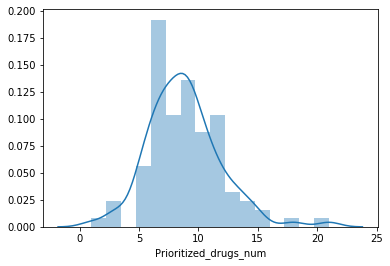

In [27]:
sns.distplot(permut_dist["Prioritized_drugs_num"])